In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

% matplotlib inline

## Base line locomotion

In [2]:
#parameters
dt = 0.6  #seconds
v_m = 0.12  #mm/s
v_s = 0.01  #std of speed
th_m = 0  #mean curving is zero
th_s = 32.3  #degrees/mm
th_cor = 12  #12 seconds helf-time

In [3]:
#Autocorrelation function
def autocorr(x):
    result = np.correlate(x, x, 'full')
    result = result[int(result.size/2):]
    return result/result[0]

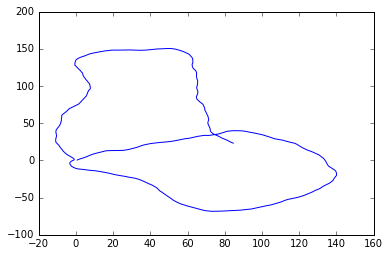

In [4]:
# initialize space-time
T = 10000
time = np.arange(0,T*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.rand()
ys[0] = np.random.rand()
ths = np.zeros(time.shape)  #agle with 1,0
ths[0] = np.random.rand()*0

#without turning (ballistic-like tragectories)
for t in range(1,len(time)):
    vv = v_m + v_s*np.random.randn()
    ths[t] = ths[t-1] + (th_m)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5  #OU process? (- ths[t-1]/th_cor + )
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)
    
    dd = np.array([vv*np.sin(ths[t-1]*np.pi/180), vv*np.cos(ths[t-1]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)
                             
    xs[t] = xs[t-1] + dxy[0] *dt
    ys[t] = ys[t-1] + dxy[1] *dt
    
plt.plot(xs,ys)

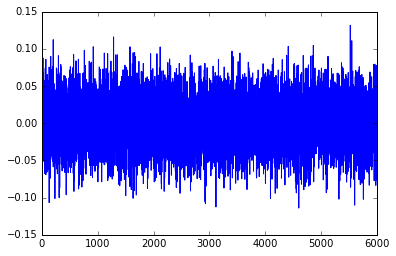

In [5]:
plt.plot(time[:-1],np.diff(ths)*np.pi/180)

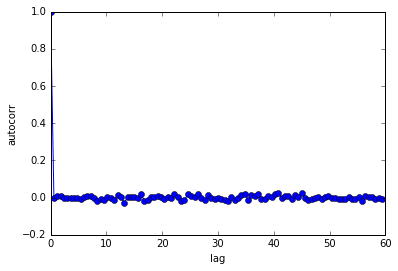

In [6]:
#plt.plot(np.arange(0,len(autocorr(ths))*dt,dt),autocorr(ths))
dth = np.diff(ths)
lag = np.arange(0,len(autocorr(dth))*dt,dt)
plt.plot(lag[0:100],autocorr(dth)[0:100],'-o')
plt.xlabel('lag')
plt.ylabel('autocorr')

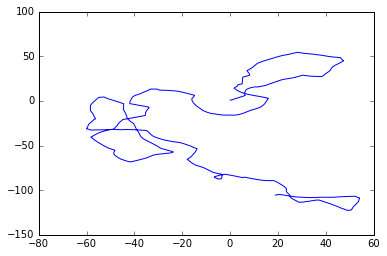

In [7]:
#with turning (switching-state)
T = 10000
time = np.arange(0,T*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.rand()
ys[0] = np.random.rand()
ths = np.zeros(time.shape)  #agle with 1,0
ths[0] = np.random.rand()*0

event_rate = 0.01
turn_m = 100

#with turning (Brownian-like tragectories)
for t in range(1,len(time)):
    vv = v_m + v_s*np.random.randn()
    ths[t] = ths[t-1] + (th_m)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5  #OU process? (- ths[t-1]/th_cor + )
    ##turns
    if np.random.poisson(event_rate/(1/dt), 1) == 1:  #Poisson rate (per second)
        ths[t] = ths[t-1] + (2*np.random.randint(2)-1)*(turn_m)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)
    
    dd = np.array([vv*np.sin(ths[t-1]*np.pi/180), vv*np.cos(ths[t-1]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)
                             
    xs[t] = xs[t-1] + dxy[0] *dt
    ys[t] = ys[t-1] + dxy[1] *dt
    
plt.plot(xs,ys)

## Gradient environment

In [8]:
#gradient environment
dis2targ = -50
C0 = 0.2
D = 0.000015
duT = 60*60*1
d = 0.18
def gradient(C0,x,y):
    concentration = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))  #depends on diffusion conditions
    return concentration

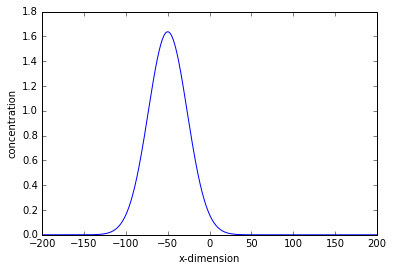

In [9]:
#plt.plot(np.arange(-200,200,0.5), C0*np.exp(-(np.arange(-200,200,0.5)-dis2targ)**2/(400*0.000015*60*60*10)))
xx = np.arange(-200,200,0.5)
plt.plot(xx,C0/(4*np.pi*d*D*duT)*np.exp(-(xx-dis2targ)**2/(400*D*duT*50)))
plt.xlabel('x-dimension')
plt.ylabel('concentration')

In [10]:
def sharp_turn_function(concentration):
    #P_event = 0.023/(0.4 + np.exp(40*concentration)) + 0.003
    P_event = 0.023/(0.4 + np.exp(140*concentration)) + 0.003
    return P_event

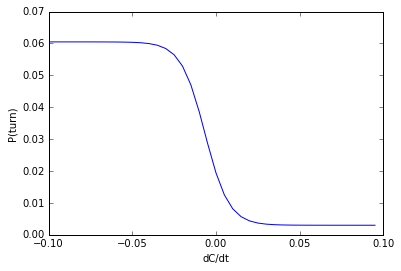

In [12]:
dcdt = np.arange(-0.1,0.1,0.005)
plt.plot(dcdt,0.023/(0.4 + np.exp(140*dcdt)) + 0.003)
plt.xlabel('dC/dt')
plt.ylabel('P(turn)')

In [12]:
def bear_function(perp_dC):
    turn_rate = 12.7 * perp_dC *0.2
    #turn_rate = 12.7 * perp_dC
    return turn_rate

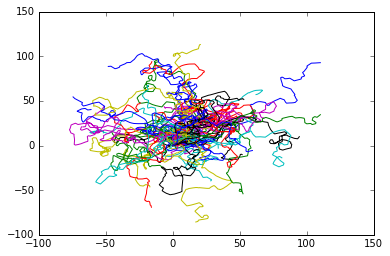

In [234]:
#Parallel locomotion strategy in gradient environment
allx = []
allth = []
for i in range(0,50):
    T = 3000
    time = np.arange(0,T*dt,dt)
    xs = np.zeros(time.shape)
    ys = np.zeros(time.shape)  #2D location
    xs[0] = np.random.randn()*0.1
    ys[0] = np.random.randn()*0.1
    ths = np.zeros(time.shape)  #agle with 1,0
    ths[0] = np.random.rand()*0

    for t in range(1,len(time)):
        ##environment
        dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])  #concentration change
        vv = v_m + v_s*np.random.randn()
        ths[t] = ths[t-1] + (th_m)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5  #OU process? (- ths[t-1]/th_cor + )
        ##sharp turns (run & tumble)
        #if np.random.poisson(sharp_turn_function(dC/dt)/(1/dt), 1) == 1:  #Poisson rate (per second)
        if np.random.rand() < sharp_turn_function(dC/dt):
            ths[t] = ths[t-1] + (2*np.random.randint(2)-1)*(turn_m)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5
        ##active sensing (weather vane)
#         else:
#             perp_dir = np.array([-dxy[1], dxy[0]])
#             perp_dir = perp_dir/np.linalg.norm(perp_dir)
#             perp_dC = gradient(C0, xs[t-1]+perp_dir[0],ys[t-1]+perp_dir[1]) - gradient(C0, xs[t-1]-perp_dir[0],ys[t-1]-perp_dir[1])
#             ths[t] = ths[t-1] + (bear_function(-perp_dC)/vv)*dt + (th_s*(vv*dt)*np.random.randn()) *dt**0.5  #head-direction!

        #update angles
        e1 = np.array([1,0])
        vec = np.array([xs[t-1],ys[t-1]])
        theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

        dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
        dxy = np.dot(R,dd)

        xs[t] = xs[t-1] + dxy[0] *dt
        ys[t] = ys[t-1] + dxy[1] *dt
    
    
    allx.append(np.array((xs,ys)))  #for statistic inference
    allth.append(ths)
    plt.plot(xs,ys)
    plt.hold(True)


In [235]:
X = np.array(allx)  #R&T strategy

In [233]:
X_wv = np.array(allx)  #combining weathervaning strategy

In [20]:
X.shape

(20, 2, 5000)

In [236]:
#first passage time
tt = time[:3000]
fstt = np.zeros(X.shape[0])
fstt_wv = np.zeros(X.shape[0])
for tr in range(0,X.shape[0]):
    if len(np.where(X[tr,0,:3000]<dis2targ)[0]) is not 0:
        fstt[tr] = time[np.where(X[tr,0,:3000]<dis2targ)[0][0]]
    if len(np.where(X_wv[tr,0,:3000]<dis2targ)[0]) is not 0:
        fstt_wv[tr] = time[np.where(X_wv[tr,0,:3000]<dis2targ)[0][0]]

(array([6., 3., 5., 3., 4., 5., 4., 1., 1., 3.]),
 array([ 549.  ,  655.14,  761.28,  867.42,  973.56, 1079.7 , 1185.84,
        1291.98, 1398.12, 1504.26, 1610.4 ]),
 <a list of 10 Patch objects>)

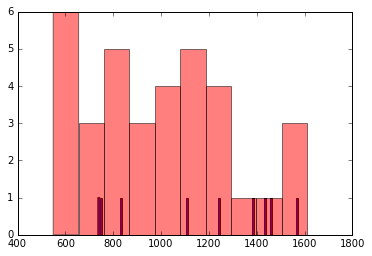

In [237]:
plt.hist(fstt[fstt!=0],bins=100)
plt.hold(True)
plt.hist(fstt_wv[fstt_wv!=0],alpha=0.5,color='r')

## Model fitting -- Switching LDS

In [14]:
import numpy.random as npr
from pyslds.models import DefaultSLDS

K = 3               # Number of discrete latent states (z)
D_obs = 1           # Observed data dimension (y)
D_latent = 2        # Latent state dimension (x)
D_input = 0         # Exogenous input dimension (u)
T = 2000            # Number of time steps to simulate (t)

true_model = DefaultSLDS(K, D_obs, D_latent, D_input)
inputs = npr.randn(T, D_input)
y, x, z = true_model.generate(T, inputs=inputs)

# Compute the log likelihood of the data with the true params
true_ll = true_model.log_likelihood() 

In [66]:
# Create a separate model and add the observed data
test_model = DefaultSLDS(K, D_obs, D_latent, D_input)
test_model.add_data(y)

# Run the Gibbs sampler
N_samples = 1000
def update(model):
    model.resample_model()
    return model.log_likelihood()

lls = [update(test_model) for _ in range(N_samples)]

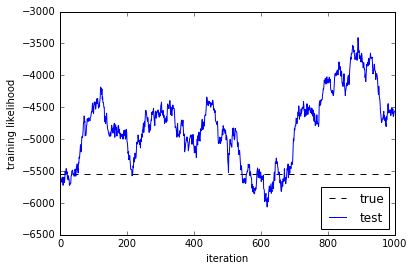

In [67]:
# Plot the log likelihoods
plt.figure()
plt.plot([0, N_samples], true_ll * np.ones(2), '--k', label="true")
plt.plot(np.arange(N_samples), lls, label="test")
plt.xlabel("iteration")
plt.ylabel("training likelihood")
plt.legend(loc="lower right")

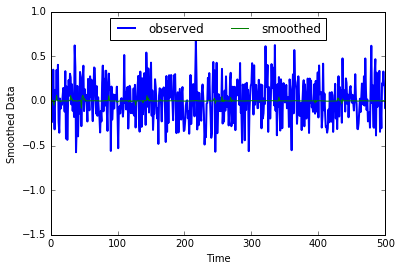

In [68]:
# Smooth the data
smoothed_data = test_model.smooth(y, inputs)

plt.figure()
plt.plot(y, lw=2, label="observed")
plt.plot(smoothed_data, lw=1, label="smoothed")
plt.xlabel("Time")
plt.xlim(0, 500)
plt.ylabel("Smoothed Data")
plt.legend(loc="upper center", ncol=2)

[]

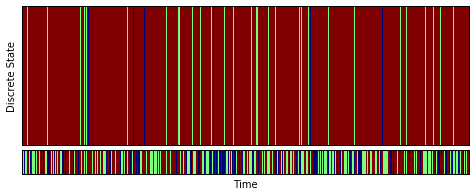

In [73]:
import matplotlib.gridspec as gridspec

n_show = 50
data = y.copy()
labels = z.copy()

samples = np.empty((n_show, data.shape[0]))
samples[:n_show] = test_model.stateseqs[0]

fig = plt.figure(figsize=(8,3))
gs = gridspec.GridSpec(6,1)
ax1 = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1], sharex=ax1)

im = ax1.matshow(samples[::-1], aspect='auto')
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel("Discrete State")
xo, yo, w, ht = ax1.bbox.bounds
h = ht / n_show

ax2.matshow(labels[None,:], aspect='auto')
ax2.set_xticks([])
ax2.set_xlabel("Time")
ax2.set_yticks([])

In [87]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Fancy plotting
try:
    import seaborn as sns
    from hips.plotting.colormaps import gradient_cmap
    sns.set_style("white")
    sns.set_context("paper")

    color_names = ["red",
                   "windows blue",
                   "medium green",
                   "dusty purple",
                   "orange",
                   "amber",
                   "clay",
                   "pink",
                   "greyish",
                   "light cyan",
                   "steel blue",
                   "forest green",
                   "pastel purple",
                   "mint",
                   "salmon",
                   "dark brown"]
    colors = sns.xkcd_palette(color_names)
    cmap = gradient_cmap(colors)
except:
    from matplotlib.cm import get_cmap
    colors = ['b', 'r', 'y', 'g', 'purple']
    cmap = get_cmap("jet")


from pybasicbayes.util.text import progprint_xrange
from pylds.util import random_rotation
from pyslds.models import DefaultSLDS

npr.seed(0)

# Set parameters
K = 5
D_obs = 100
D_latent = 2
D_input = 1
T = 1000

# Make an LDS with known parameters
true_mu_inits = [np.ones(D_latent) for _ in range(K)]
true_sigma_inits = [np.eye(D_latent) for _ in range(K)]
true_As = [.9 * random_rotation(D_latent)
           for k in range(K)]
true_Bs = [3 * npr.randn(D_latent, D_input) for k in range(K)]
true_sigma_states = [np.eye(D_latent) for _ in range(K)]
true_C = np.random.randn(D_obs, D_latent)
true_Ds = np.zeros((D_obs, D_input))
true_sigma_obs = np.eye(D_obs)
true_model = DefaultSLDS(
    K, D_obs, D_latent, D_input=D_input,
    mu_inits=true_mu_inits, sigma_inits=true_sigma_inits,
    As=true_As, Bs=true_Bs, sigma_statess=true_sigma_states,
    Cs=true_C, Ds=true_Ds, sigma_obss=true_sigma_obs)

# Simulate some data with a given discrete state sequence
inputs = np.ones((T, D_input))
z = np.arange(K).repeat(T // K)
y, x, z = true_model.generate(T, inputs=inputs, stateseq=z)

# Fit with another LDS.  Give it twice as many states in
# order to have some flexibility during inference.
test_model = DefaultSLDS(2*K, D_obs, D_latent, D_input,
                         Cs=npr.randn(D_obs, D_latent),
                         Ds=npr.randn(D_obs, D_input))
test_model.add_data(y, inputs=inputs)

# Initialize with Gibbs sampler
print("Initializing with Gibbs")
N_gibbs_samples = 1000
def initialize(model):
    model.resample_model()
    return model.log_likelihood()

gibbs_lls = [initialize(test_model) for _ in progprint_xrange(N_gibbs_samples)]

# Fit with VBEM
print("Fitting with VBEM")
N_vbem_iters = 100
def update(model):
    model.VBEM_step()
    return model.log_likelihood()

Initializing with Gibbs
.........................  [   25/1000,    0.14sec avg, ETA 02:17 ]
.........................  [   50/1000,    0.15sec avg, ETA 02:22 ]
.........................  [   75/1000,    0.14sec avg, ETA 02:13 ]
.........................  [  100/1000,    0.14sec avg, ETA 02:09 ]
.........................  [  125/1000,    0.14sec avg, ETA 02:04 ]
.........................  [  150/1000,    0.14sec avg, ETA 01:57 ]
.........................  [  175/1000,    0.14sec avg, ETA 01:52 ]
.........................  [  200/1000,    0.13sec avg, ETA 01:47 ]
.........................  [  225/1000,    0.13sec avg, ETA 01:43 ]
.........................  [  250/1000,    0.13sec avg, ETA 01:40 ]
.........................  [  275/1000,    0.13sec avg, ETA 01:36 ]
.........................  [  300/1000,    0.13sec avg, ETA 01:32 ]
.........................  [  325/1000,    0.13sec avg, ETA 01:30 ]
.........................  [  350/1000,    0.13sec avg, ETA 01:27 ]
........................

In [103]:
# test_model._init_mf_from_gibbs()
# vbem_lls = [update(test_model) for _ in progprint_xrange(N_vbem_iters)]

# # Plot the log likelihoods
# plt.figure(figsize=(5,3))
# plt.plot([0, N_gibbs_samples + N_vbem_iters], true_model.log_likelihood() * np.ones(2), '--k', label="true")
# plt.plot(np.arange(N_gibbs_samples), gibbs_lls, color=colors[0], label="gibbs")
# plt.plot(np.arange(N_gibbs_samples + 1, N_gibbs_samples + N_vbem_iters), vbem_lls[1:], color=colors[1], label="vbem")
# plt.xlim(0, N_gibbs_samples + N_vbem_iters)
# plt.xlabel('iteration')
# plt.ylabel('log likelihood')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.savefig("aux/demo_ll.png")

# Smooth the data
smoothed_data = test_model.smooth(y, inputs)

fig = plt.figure(figsize=(5,3))
gs = GridSpec(3, 1, height_ratios=[.1, .1, 1.0])
ax = fig.add_subplot(gs[0,0])
ax.imshow(true_model.states_list[0].stateseq[None,:], vmin=0, vmax=max(len(colors), true_model.num_states)-1,
          cmap=cmap, interpolation="nearest", aspect="auto")
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title("True Discrete States")

ax = fig.add_subplot(gs[1,0])
ax.imshow(test_model.states_list[0].stateseq[None,:], vmin=0, vmax=max(len(colors), test_model.num_states)-1,
          cmap=cmap, interpolation="nearest", aspect="auto")
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title("Inferred Discrete States")

ax = fig.add_subplot(gs[2,0])
plt.plot(y[:,0], color='k', lw=2, label="observed")
plt.plot(smoothed_data[:,0], color=colors[0], lw=1, label="smoothed")
plt.xlabel("Time")
plt.xlim(0, min(T, 500))
plt.ylabel("Observations")
plt.legend(loc="upper center", ncol=2)
plt.tight_layout()
plt.savefig("aux/demo_smooth.png")

plt.figure()
from pyhsmm.util.general import rle
z_rle = rle(z)
offset = 0
for k, dur in zip(*z_rle):
    plt.plot(x[offset:offset+dur,0], x[offset:offset+dur,1], color=colors[k])
    offset += dur

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Continuous Latent States")
plt.show()

ValueError: shapes (1000,2) and (3,100) not aligned: 2 (dim 1) != 3 (dim 0)

## Model fitting -- Gaussian Process

Following similar fitting examples on: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

In [15]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [16]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [29]:
X = np.asarray(allx)[:,0,:].copy() #x-axis first --> position
y = time #--> time step axis

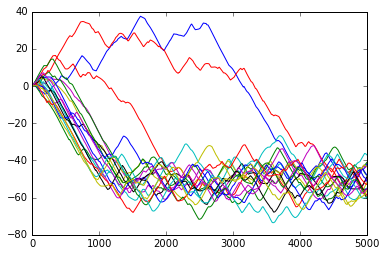

In [30]:
plt.plot(X.T);

In [ ]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(np.expand_dims(y[:2000],axis=1), X[:,:2000].T)
# gaussian_process.GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                          kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1), 
#                          n_restarts_optimizer=0, normalize_y=False,
#                          optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
x_pred = np.expand_dims(y[:2000],axis=1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

NameError: name 'gp' is not defined

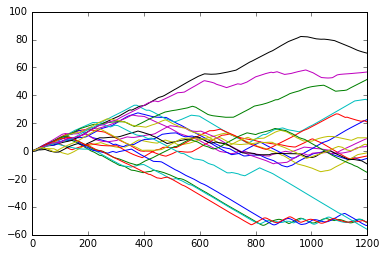

In [48]:
plt.plot(x_pred, y_pred)
plt.hold(True)
#plt.fill_between(x_pred, y_pred-np.expand_dims(sigma,axis=0).T, y_pred+np.expand_dims(sigma,axis=0).T)

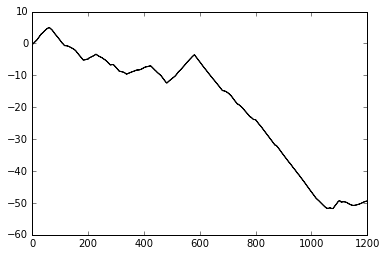

In [53]:
ii = 10
plt.fill_between(np.squeeze(x_pred), y_pred[:,ii]-sigma, y_pred[:,ii]+sigma)

## Angle-position fitting

In [184]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Exponentiation

### Ideas

- spatial binning
- GP for angle and reconstruct trajectroies
- measure correlation

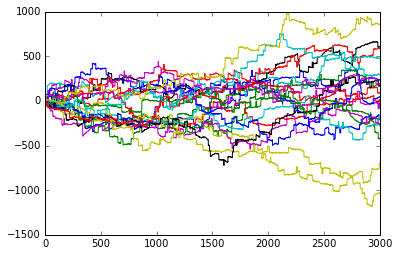

In [185]:
TH = np.array(allth).copy()
plt.plot(TH[:,:3000].T);

In [186]:
X = np.asarray(allx)[:,0,:].copy() #x-axis first --> position
y = TH.copy()  #using head angle as a predictor
#y = time #--> time step axis

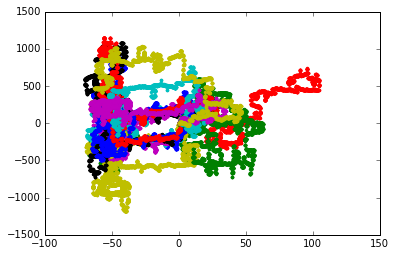

In [187]:
plt.plot(X.T,y.T,'.'); #position vs. angle (predicted!)

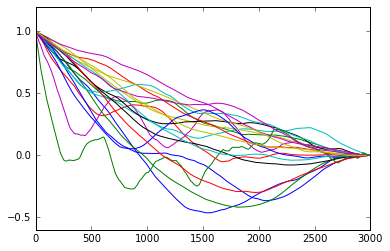

In [206]:
#autocorrelation
for tr in range(0,y.shape[0]):
    plt.plot(autocorr(y[tr,:3000]))
    plt.hold(True)

In [188]:
#binning space
xx = np.linspace(-100,100,100)
Xb = np.zeros(X.shape)
for tr in range(0,X.shape[0]):
    for ii in range(0,X.shape[1]):
        Xb[tr,ii] = xx[np.argmin(np.abs(X[tr,ii]-xx))]

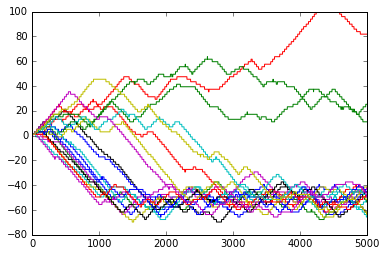

In [189]:
plt.plot(Xb.T);

In [190]:
def ang_to_trajectory(ths,vm):
    '''
    Input time series of head angles (trials X time) and the mean of running length
    Output is the reconstructed 2-D trajectoris
    '''
    tracks = np.zeros((ths.shape[0],2,ths.shape[1]))  #trials X x-y X time
    tracks[:,:,0] = np.random.randn(ths.shape[0],2)*0.1  #initial condition
    for tr in range(0,ths.shape[0]):  #trial
        for tt in range(1,ths.shape[1]):  #time
            #relative angle
            e1 = np.array([1,0])
            vec = np.array([tracks[tr,0,tt-1],tracks[tr,1,tt-1]])
            theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1))  #angle
            #polar coordinate
            dd = np.array([vm*np.sin(ths[tr,tt]*np.pi/180), vm*np.cos(ths[tr,tt]*np.pi/180)])  #displacement
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
            dxy = np.dot(R,dd)
            #update position
            tracks[tr,0,tt] = tracks[tr,0,tt-1] + dxy[0] *dt
            tracks[tr,1,tt] = tracks[tr,1,tt-1] + dxy[1] *dt
    return tracks

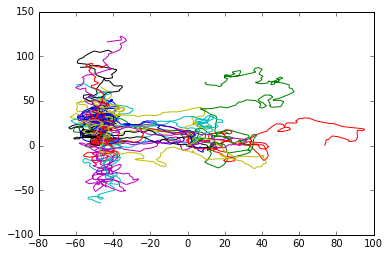

In [191]:
tracks = ang_to_trajectory(TH,vv)
for i in range(0,tracks.shape[0]):
    plt.plot(np.squeeze(tracks[i,0,:]), np.squeeze(tracks[i,1,:]))
    plt.hold(True)

In [207]:
kernel_RBF = RBF(length_scale=3)
kernel_exp = Exponentiation

gp = gaussian_process.GaussianProcessRegressor(kernel = RBF(length_scale=300))#kernel_exp(kernel_RBF, 1))
# gp = gaussian_process.GaussianProcessRegressor(kernel = kernel_exp(kernel_RBF, 1), 
#                                                n_restarts_optimizer=0, normalize_y=False,
#                                                optimizer='fmin_l_bfgs_b', random_state=None)
#gp.fit(np.expand_dims(y[:3000],axis=1), X[:,:3000].T)
#gp.fit(Xb[:,:3000], y[:,:3000])  #use position to predict angle
gp.fit(np.expand_dims(time[:3000],axis=1), y[:10,:3000].T)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=300), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [219]:
gp.kernel_.theta

array([-11.51292546])

In [227]:
#log-marginal likelihood test for hyperparameter
ls = np.logspace(0,3,10)
LML = []
for ll in ls:
    gp = gaussian_process.GaussianProcessRegressor(kernel = RBF(length_scale=ll))
    gp.fit(np.expand_dims(time[:3000],axis=1), y[:10,:3000].T)
    LML.append(gp.log_marginal_likelihood(gp.kernel_.theta))

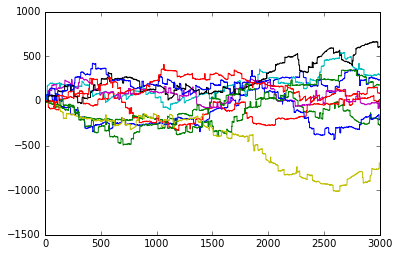

In [208]:
#x_pred = np.expand_dims(y[:3000],axis=1)
#x_pred = X[:,:3000]
x_pred = np.expand_dims(time[:3000],axis=1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
plt.plot(y_pred);

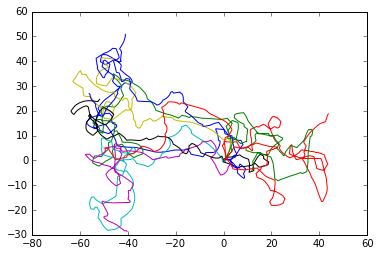

In [216]:
tracks = ang_to_trajectory(y_pred.T,vv)
for i in range(0,tracks.shape[0]):
    plt.plot(np.squeeze(tracks[i,0,:]), np.squeeze(tracks[i,1,:]))
    plt.hold(True)

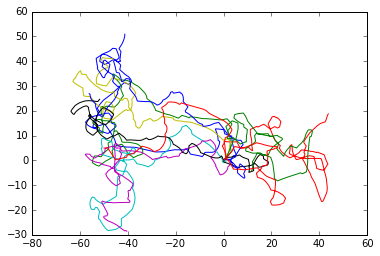

In [218]:
plt.figure()
tracks_ = ang_to_trajectory(y[:10,:3000],vv)
for i in range(0,tracks.shape[0]):
    #plt.plot(np.squeeze(tracks_[i,0,:])-np.squeeze(tracks[i,0,:]), np.squeeze(tracks_[i,1,:])-np.squeeze(tracks[i,0,:]))
    plt.plot(np.squeeze(tracks_[i,0,:]), np.squeeze(tracks_[i,1,:]))
    plt.hold(True)

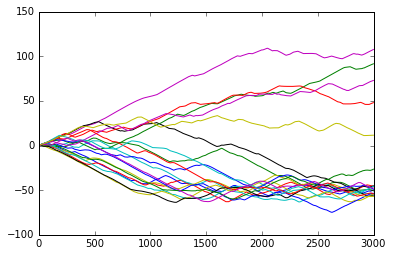

In [34]:
X = np.asarray(allx)[:,0,:].copy() #x-axis first --> position
plt.plot(X[:,:3000].T);

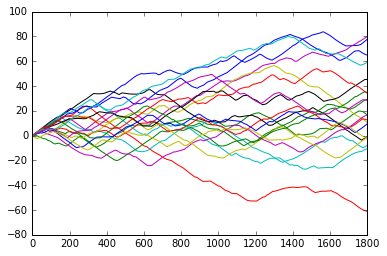

In [78]:
#y-axis (better way to fit 2-D random walk?)
Y = np.asarray(allx)[:,1,:]
y = time #--> time step axis

gp.fit(np.expand_dims(y[:3000],axis=1), Y[:,:3000].T)

x_pred = np.expand_dims(y[:3000],axis=1)
Y_pred, sigma = gp.predict(x_pred, return_std=True)
plt.plot(x_pred, Y_pred);

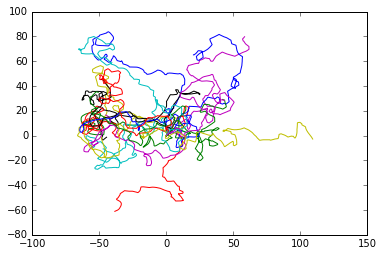

In [79]:
plt.plot(y_pred,Y_pred);  #independent fitting for two-dimensions